# MOGDx 

In [1]:
import pandas as pd
import numpy as np
import os
import sys 

sys.path.insert(0 , './../')
from MAIN.utils import *
from MAIN.train import *
import MAIN.preprocess_functions
from MAIN.GNN_MME import GCN_MME , GSage_MME , GAT_MME

from Modules.PNetTorch.MAIN.reactome import ReactomeNetwork
from Modules.PNetTorch.MAIN.Pnet import MaskedLinear , PNET
from Modules.PNetTorch.MAIN.utils import numpy_array_to_one_hot, get_gpu_memory
from Modules.PNetTorch.MAIN.interpret import interpret , evaluate_interpret_save

import torch
import torch.nn.functional as F
import dgl
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import networkx as nx
from datetime import datetime
import joblib
import warnings
import gc

warnings.filterwarnings("ignore")

print("Finished Library Import \n")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Finished Library Import 



In [2]:
data_input = './../../data/raw/'
snf_net = 'RPPA_mRNA_graph.graphml'
index_col = 'index'
target = 'paper_BRCA_Subtype_PAM50'

In [3]:
# List of cancer genes was taken from the PNet paper dataset
genes = pd.read_csv('./../../data/ext_data/cancer_genes.txt', header=0)

# Build network to obtain gene and pathway relationships
net = ReactomeNetwork(genes_of_interest=np.unique(list(genes['genes'].values)) , n_levels=5)

Using cuda device
Total = 6.4Gb 	 Reserved = 0.0Gb 	 Allocated = 0.0Gb
StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
GSage_MME(
  (encoder_dims): ModuleList(
    (0): PNET(
      (dropout): Dropout(p=0.5, inplace=False)
      (layers): ModuleList(
        (0): Linear(in_features=464, out_features=723, bias=True)
        (1): MaskedLinear(in_features=723, out_features=1613, bias=True)
        (2): MaskedLinear(in_features=1613, out_features=1107, bias=True)
        (3): MaskedLinear(in_features=1107, out_features=488, bias=True)
        (4): MaskedLinear(in_features=488, out_features=159, bias=True)
        (5): MaskedLinear(in_features=159, out_features=28, bias=True)
      )
      (skip): ModuleList(
        (0): Linear(in_features=723, out_features=32, bias=True)
        (1): Linear(in_features=1613, out_features=32, bias=True)
        (2): Linear(in_features=1107, out_features=32, bias=True)
        (3): Linear(in_features=488, out_features=32, bias=True)
        (4):

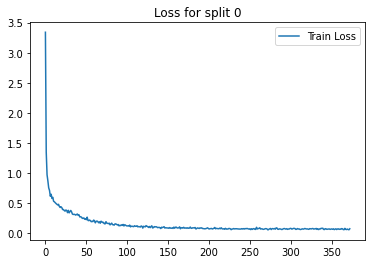

Fold : 1 | Test Accuracy = 0.8657 | F1 = 0.8322 
Total = 6.4Gb 	 Reserved = 1.2Gb 	 Allocated = 0.4Gb
Clearing gpu memory
Total = 6.4Gb 	 Reserved = 0.6Gb 	 Allocated = 0.4Gb
GSage_MME(
  (encoder_dims): ModuleList(
    (0): PNET(
      (dropout): Dropout(p=0.5, inplace=False)
      (layers): ModuleList(
        (0): Linear(in_features=464, out_features=723, bias=True)
        (1): MaskedLinear(in_features=723, out_features=1613, bias=True)
        (2): MaskedLinear(in_features=1613, out_features=1107, bias=True)
        (3): MaskedLinear(in_features=1107, out_features=488, bias=True)
        (4): MaskedLinear(in_features=488, out_features=159, bias=True)
        (5): MaskedLinear(in_features=159, out_features=28, bias=True)
      )
      (skip): ModuleList(
        (0): Linear(in_features=723, out_features=32, bias=True)
        (1): Linear(in_features=1613, out_features=32, bias=True)
        (2): Linear(in_features=1107, out_features=32, bias=True)
        (3): Linear(in_features=48

Epoch 00395 | Loss 0.0653 | Train Acc. 0.9884 | 
Epoch 00400 | Loss 0.0647 | Train Acc. 0.9849 | 
Epoch 00405 | Loss 0.0713 | Train Acc. 0.9884 | 
Epoch 00410 | Loss 0.0730 | Train Acc. 0.9826 | 
Epoch 00415 | Loss 0.0733 | Train Acc. 0.9837 | 
Epoch 00420 | Loss 0.0703 | Train Acc. 0.9814 | 
Epoch 00425 | Loss 0.0725 | Train Acc. 0.9803 | 
Epoch 00430 | Loss 0.0727 | Train Acc. 0.9861 | 
Epoch 00435 | Loss 0.0712 | Train Acc. 0.9826 | 
Epoch 00440 | Loss 0.0834 | Train Acc. 0.9803 | 
Epoch 00445 | Loss 0.0596 | Train Acc. 0.9884 | 
Epoch 00450 | Loss 0.0681 | Train Acc. 0.9872 | 
Epoch 00455 | Loss 0.0810 | Train Acc. 0.9779 | 
Epoch 00460 | Loss 0.0779 | Train Acc. 0.9803 | 
Epoch 00465 | Loss 0.0731 | Train Acc. 0.9861 | 
Epoch 00470 | Loss 0.0755 | Train Acc. 0.9837 | 
Epoch 00475 | Loss 0.0676 | Train Acc. 0.9861 | 
Epoch 00480 | Loss 0.0667 | Train Acc. 0.9837 | 
Epoch 00485 | Loss 0.0738 | Train Acc. 0.9791 | 
Epoch 00490 | Loss 0.0661 | Train Acc. 0.9907 | 
Epoch 00495 | Loss 0

<Figure size 432x288 with 0 Axes>

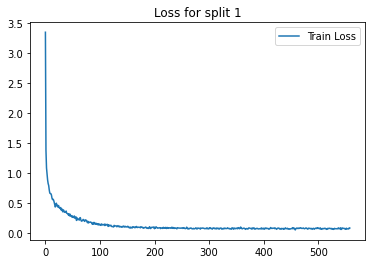

Fold : 2 | Test Accuracy = 0.8837 | F1 = 0.8583 
Total = 6.4Gb 	 Reserved = 1.4Gb 	 Allocated = 0.4Gb
Clearing gpu memory
Total = 6.4Gb 	 Reserved = 0.6Gb 	 Allocated = 0.4Gb
GSage_MME(
  (encoder_dims): ModuleList(
    (0): PNET(
      (dropout): Dropout(p=0.5, inplace=False)
      (layers): ModuleList(
        (0): Linear(in_features=464, out_features=723, bias=True)
        (1): MaskedLinear(in_features=723, out_features=1613, bias=True)
        (2): MaskedLinear(in_features=1613, out_features=1107, bias=True)
        (3): MaskedLinear(in_features=1107, out_features=488, bias=True)
        (4): MaskedLinear(in_features=488, out_features=159, bias=True)
        (5): MaskedLinear(in_features=159, out_features=28, bias=True)
      )
      (skip): ModuleList(
        (0): Linear(in_features=723, out_features=32, bias=True)
        (1): Linear(in_features=1613, out_features=32, bias=True)
        (2): Linear(in_features=1107, out_features=32, bias=True)
        (3): Linear(in_features=48

Epoch 00395 | Loss 0.0709 | Train Acc. 0.9826 | 
Epoch 00400 | Loss 0.0685 | Train Acc. 0.9826 | 
Epoch 00405 | Loss 0.0688 | Train Acc. 0.9837 | 
Epoch 00410 | Loss 0.0678 | Train Acc. 0.9837 | 
Epoch 00415 | Loss 0.0633 | Train Acc. 0.9849 | 
Early stopping! No improvement for 100 consecutive epochs.


<Figure size 432x288 with 0 Axes>

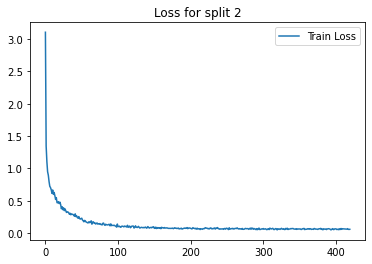

Fold : 3 | Test Accuracy = 0.8791 | F1 = 0.8472 
Total = 6.4Gb 	 Reserved = 1.5Gb 	 Allocated = 0.6Gb
Clearing gpu memory
Total = 6.4Gb 	 Reserved = 0.6Gb 	 Allocated = 0.4Gb
GSage_MME(
  (encoder_dims): ModuleList(
    (0): PNET(
      (dropout): Dropout(p=0.5, inplace=False)
      (layers): ModuleList(
        (0): Linear(in_features=464, out_features=723, bias=True)
        (1): MaskedLinear(in_features=723, out_features=1613, bias=True)
        (2): MaskedLinear(in_features=1613, out_features=1107, bias=True)
        (3): MaskedLinear(in_features=1107, out_features=488, bias=True)
        (4): MaskedLinear(in_features=488, out_features=159, bias=True)
        (5): MaskedLinear(in_features=159, out_features=28, bias=True)
      )
      (skip): ModuleList(
        (0): Linear(in_features=723, out_features=32, bias=True)
        (1): Linear(in_features=1613, out_features=32, bias=True)
        (2): Linear(in_features=1107, out_features=32, bias=True)
        (3): Linear(in_features=48

<Figure size 432x288 with 0 Axes>

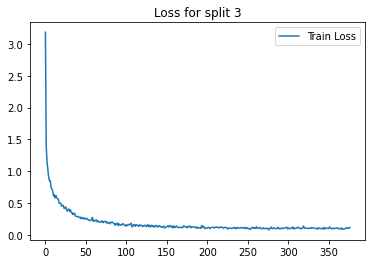

Fold : 4 | Test Accuracy = 0.8419 | F1 = 0.8151 
Total = 6.4Gb 	 Reserved = 1.5Gb 	 Allocated = 0.6Gb
Clearing gpu memory
Total = 6.4Gb 	 Reserved = 0.6Gb 	 Allocated = 0.4Gb
GSage_MME(
  (encoder_dims): ModuleList(
    (0): PNET(
      (dropout): Dropout(p=0.5, inplace=False)
      (layers): ModuleList(
        (0): Linear(in_features=464, out_features=723, bias=True)
        (1): MaskedLinear(in_features=723, out_features=1613, bias=True)
        (2): MaskedLinear(in_features=1613, out_features=1107, bias=True)
        (3): MaskedLinear(in_features=1107, out_features=488, bias=True)
        (4): MaskedLinear(in_features=488, out_features=159, bias=True)
        (5): MaskedLinear(in_features=159, out_features=28, bias=True)
      )
      (skip): ModuleList(
        (0): Linear(in_features=723, out_features=32, bias=True)
        (1): Linear(in_features=1613, out_features=32, bias=True)
        (2): Linear(in_features=1107, out_features=32, bias=True)
        (3): Linear(in_features=48

Epoch 00395 | Loss 0.0540 | Train Acc. 0.9895 | 
Epoch 00400 | Loss 0.0578 | Train Acc. 0.9872 | 
Epoch 00405 | Loss 0.0642 | Train Acc. 0.9826 | 
Epoch 00410 | Loss 0.0521 | Train Acc. 0.9919 | 
Epoch 00415 | Loss 0.0493 | Train Acc. 0.9930 | 
Epoch 00420 | Loss 0.0573 | Train Acc. 0.9861 | 
Epoch 00425 | Loss 0.0486 | Train Acc. 0.9895 | 
Early stopping! No improvement for 100 consecutive epochs.


<Figure size 432x288 with 0 Axes>

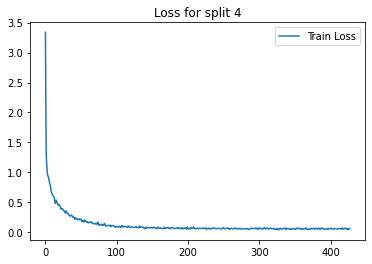

Fold : 5 | Test Accuracy = 0.8372 | F1 = 0.7992 
Total = 6.4Gb 	 Reserved = 1.5Gb 	 Allocated = 0.6Gb
Clearing gpu memory
Total = 6.4Gb 	 Reserved = 0.6Gb 	 Allocated = 0.4Gb
5 Fold Cross Validation Accuracy = 86.15 ± 1.90
5 Fold Cross Validation F1 = 83.04 ± 2.13


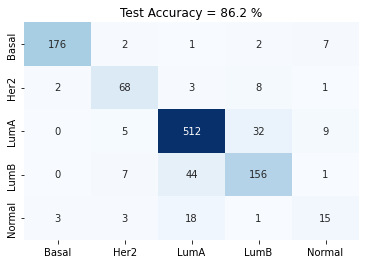

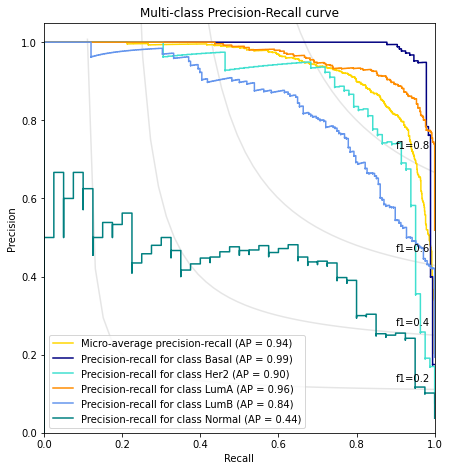

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')# Get GPU device name, else use CPU
print("Using %s device" % device)
get_gpu_memory()

datModalities , meta = data_parsing(data_input , ['RPPA', 'mRNA' ] , target , index_col)

graph_file = data_input + '../Networks/' + snf_net
g = nx.read_graphml(graph_file)

meta = meta.loc[sorted(meta.index)]
label = F.one_hot(torch.Tensor(list(meta.astype('category').cat.codes)).to(torch.int64))

skf = StratifiedKFold(n_splits=5 , shuffle=True) 

print(skf)

MME_input_shapes = [ datModalities[mod].shape[1] for mod in datModalities]

h = reduce(merge_dfs , list(datModalities.values()))
h = h.loc[sorted(h.index)]

g = dgl.from_networkx(g , node_attrs=['idx' , 'label'])

g.ndata['feat'] = torch.Tensor(h.to_numpy())

g.ndata['label'] = label

del datModalities
gc.collect()

output_metrics = []
test_logits = []
test_labels = []
for i, (train_index, test_index) in enumerate(skf.split(meta.index, meta)) :

    model = GSage_MME(MME_input_shapes , [16 , 32] , 32 , [16]  , len(meta.unique()), PNet=net).to(device)
    
    print(model)
    print(g)
    
    g = g.to(device)

    loss_plot = train(g, train_index, device ,  model , label , 2000 , 1e-3 , 100)
    plt.title(f'Loss for split {i}')
    plt.show()
    plt.clf()
    
    sampler = NeighborSampler(
        [15 for i in range(len(model.gnnlayers))],  # fanout for each layer
        prefetch_node_feats=['feat'],
        prefetch_labels=['label'],
    )
    test_dataloader = DataLoader(
        g,
        torch.Tensor(test_index).to(torch.int64).to(device),
        sampler,
        device=device,
        batch_size=1024,
        shuffle=True,
        drop_last=False,
        num_workers=0,
        use_uva=False,
    )
    
    test_output_metrics = evaluate(model , g, test_dataloader)

    print(
        "Fold : {:01d} | Test Accuracy = {:.4f} | F1 = {:.4f} ".format(
        i+1 , test_output_metrics[1] , test_output_metrics[2] )
    )
    
    test_logits.extend(test_output_metrics[-2])
    test_labels.extend(test_output_metrics[-1])
    
    output_metrics.append(test_output_metrics)
    if i == 0 : 
        best_model = model
        best_idx = i
    elif output_metrics[best_idx][1] < test_output_metrics[1] : 
        best_model = model
        best_idx   = i

    get_gpu_memory()
    del model
    gc.collect()
    torch.cuda.empty_cache()
    print('Clearing gpu memory')
    get_gpu_memory()

test_logits = torch.stack(test_logits)
test_labels = torch.stack(test_labels)
    
accuracy = []
F1 = []
i = 0
for metric in output_metrics :
    
    accuracy.append(metric[1])
    F1.append(metric[2])


print("%i Fold Cross Validation Accuracy = %2.2f \u00B1 %2.2f" %(5 , np.mean(accuracy)*100 , np.std(accuracy)*100))
print("%i Fold Cross Validation F1 = %2.2f \u00B1 %2.2f" %(5 , np.mean(F1)*100 , np.std(F1)*100))

confusion_matrix(test_logits , test_labels , meta.astype('category').cat.categories)
plt.title('Test Accuracy = %2.1f %%' % (np.mean(accuracy)*100))

precision_recall_plot , all_predictions_conf = AUROC(test_logits, test_labels , meta)

node_predictions = []
node_true        = []
display_label = meta.astype('category').cat.categories
for pred , true in zip(all_predictions_conf.argmax(1) , list(test_labels.detach().cpu().argmax(1).numpy()))  : 
    node_predictions.append(display_label[pred])
    node_true.append(display_label[true])

tst = pd.DataFrame({'Actual' : node_true , 'Predicted' : node_predictions})

In [9]:
get_gpu_memory()
#del model , train_loader , test_loader
torch.cuda.reset_accumulated_memory_stats()
gc.collect()
torch.cuda.empty_cache()
get_gpu_memory()

Total = 6.4Gb 	 Reserved = 1.0Gb 	 Allocated = 0.4Gb
Total = 6.4Gb 	 Reserved = 0.6Gb 	 Allocated = 0.4Gb


In [6]:
# test the model
print("Testing...")
acc = layerwise_infer(
    device, g, np.arange(len(g.nodes())), best_model, batch_size=4096
)
print("Test Accuracy {:.4f}".format(acc.item()))

Testing...


100%|██████████| 1/1 [00:00<00:00, 32.70it/s]

Test Accuracy 0.9749


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


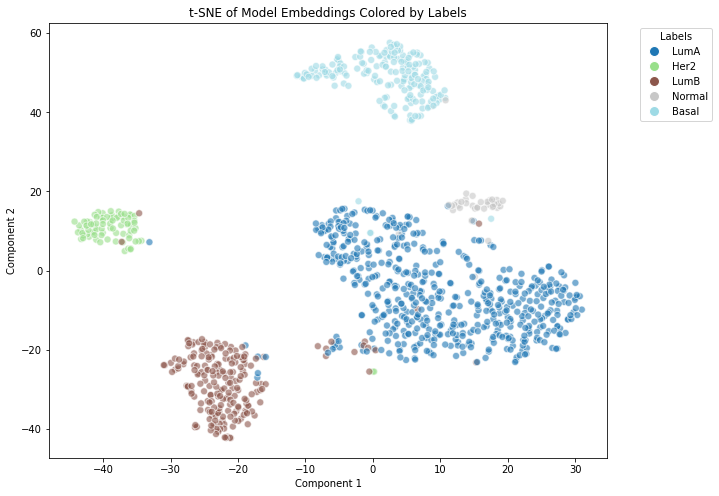

In [7]:
best_model.eval()
with torch.no_grad():
    emb = best_model.embedding_extraction(
        g, g.ndata['feat'] ,device, 4096
    )  # pred in buffer_device

tsne_embedding_plot(emb.detach().cpu().numpy() , meta)

Save Path Not Found - Plots will not be saved


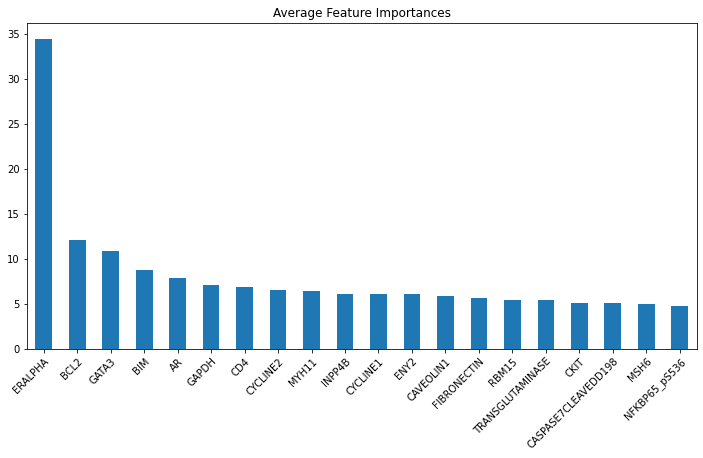

Linear(in_features=464, out_features=723, bias=True)
MaskedLinear(in_features=723, out_features=1613, bias=True)
MaskedLinear(in_features=1613, out_features=1107, bias=True)
MaskedLinear(in_features=1107, out_features=488, bias=True)
MaskedLinear(in_features=488, out_features=159, bias=True)
MaskedLinear(in_features=159, out_features=28, bias=True)


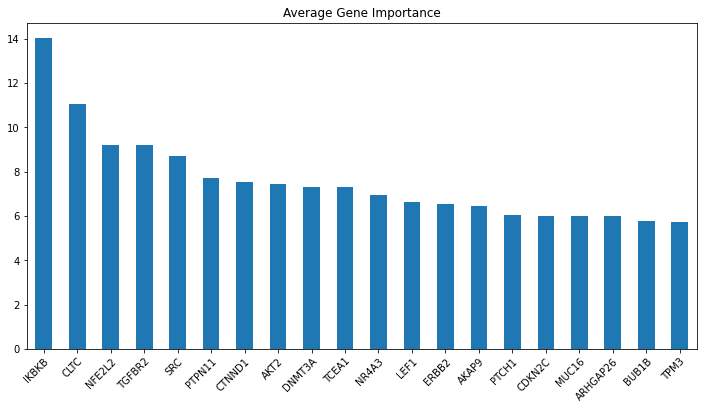

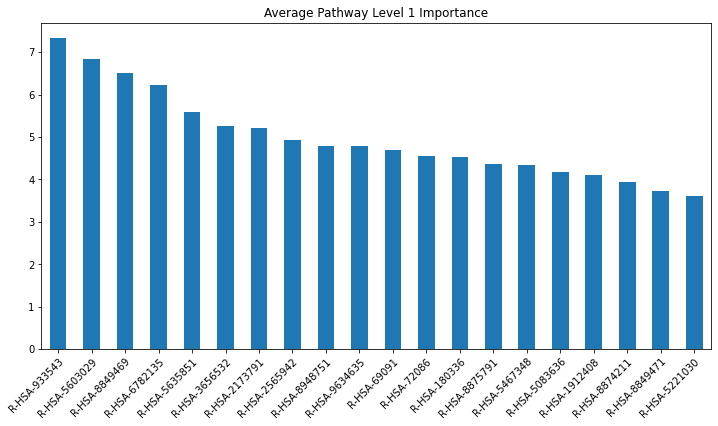

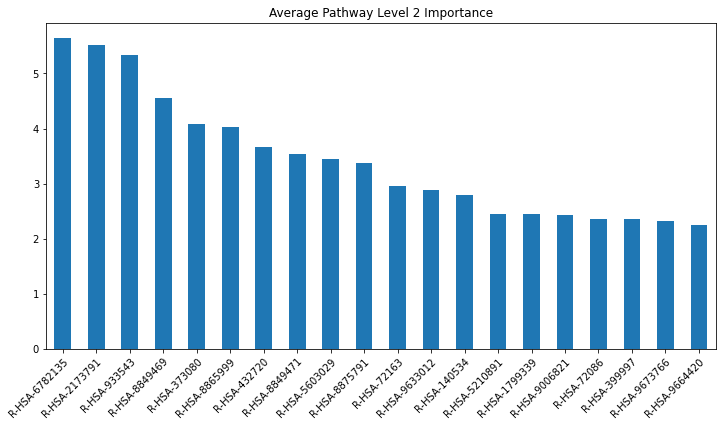

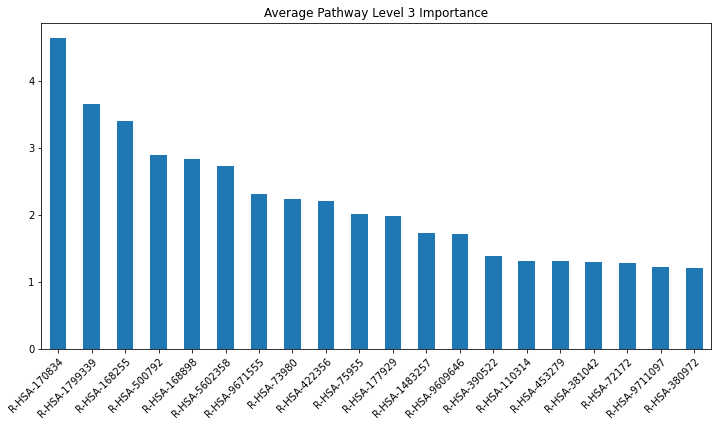

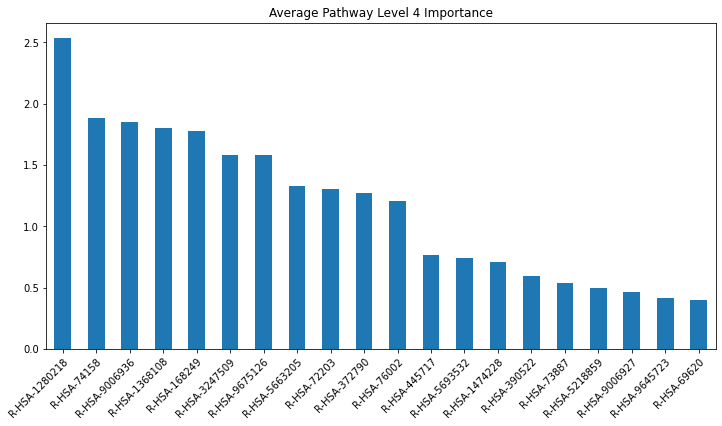

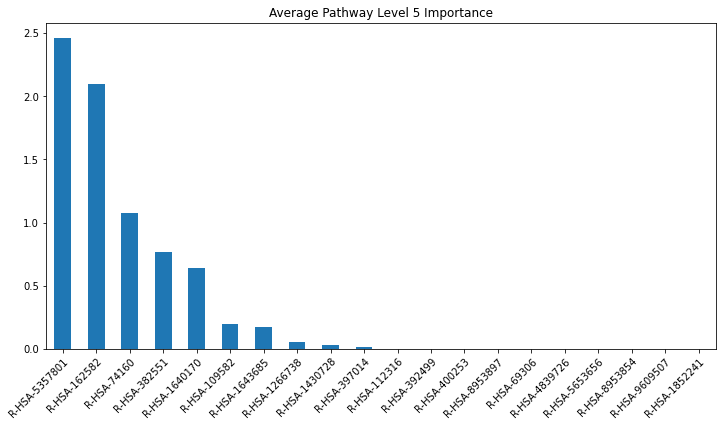

In [15]:
datModalities , meta = data_parsing(data_input , ['RPPA', 'mRNA' ] , target , index_col)

best_model.encoder_dims[0].features = datModalities['RPPA'].columns

h_torch = torch.Tensor(h.values)
x = h_torch[: , :464]
n = x.shape[0]
nan_rows = torch.isnan(x).any(dim=1)
test_data = x[~nan_rows].to(device)

model_importances = interpret(best_model.encoder_dims[0] , test_data , savedir='None')

In [16]:
get_gpu_memory()
#del model , train_loader , test_loader
torch.cuda.reset_accumulated_memory_stats()
gc.collect()
torch.cuda.empty_cache()
get_gpu_memory()

Total = 6.4Gb 	 Reserved = 4.1Gb 	 Allocated = 0.4Gb
Total = 6.4Gb 	 Reserved = 0.6Gb 	 Allocated = 0.4Gb


Save Path Not Found - Plots will not be saved


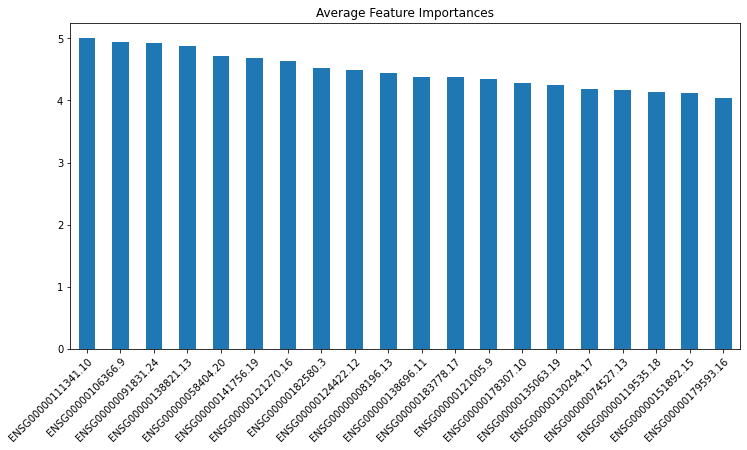

Linear(in_features=29995, out_features=723, bias=True)
MaskedLinear(in_features=723, out_features=1613, bias=True)
MaskedLinear(in_features=1613, out_features=1107, bias=True)


OutOfMemoryError: CUDA out of memory. Tried to allocate 5.97 GiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 13.04 GiB is allocated by PyTorch, and 2.81 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [17]:
datModalities , meta = data_parsing(data_input , ['RPPA', 'mRNA' ] , target , index_col)

best_model.encoder_dims[1].features = datModalities['mRNA'].columns

h_torch = torch.Tensor(h.values)
x = h_torch[: , 464:]
n = x.shape[0]
nan_rows = torch.isnan(x).any(dim=1)
test_data = x[~nan_rows].to(device)

model_importances = interpret(best_model.encoder_dims[1] , test_data , savedir='None')